In [1]:
import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import time
import numpy as np
import os
import argparse

from contact_dataset import makeTrainValidDataLoaders, makeTestDataLoaders
from blazehand_contact import BlazeHandContact

torch.set_grad_enabled(True)
use_gpu = torch.cuda.is_available()
print("use_gpu:{}".format(use_gpu))

parser = argparse.ArgumentParser(description="PyTorch implementation of SENet")
parser.add_argument('--data_root_path', type=str, default="../all")
parser.add_argument('--batch_size',  type=int, default=140)
parser.add_argument('--val_ratio',   type=float, default=0.2)
parser.add_argument('--num_class',   type=int, default=6)
parser.add_argument('--num_epochs',  type=int, default=100)
parser.add_argument('--lr',          type=float, default=0.0001)
parser.add_argument('--num_workers', type=int, default=0)
parser.add_argument('--gpus',        type=str, default=0)
parser.add_argument('--print_freq',  type=int, default=10)
parser.add_argument('--save_epoch_freq', type=int, default=1)
parser.add_argument('--save_path',   type=str, default = "./mini_checkpoints")
parser.add_argument('--resume',      type=str, default="", help="For training from one checkpoint")
parser.add_argument('--start-epoch', type=int, default=0, help="Corresponding to the epoch of resume ")
args = parser.parse_args(
    args = "--resume ./checkpoints/epoch_1_1668143324.pth".split()
)


from contact_dataset import ContactDataSet
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split

def makeTrainValidDataLoaders(
    data_root_path,
    num_data,
    val_ratio,
    batch_size
) :

    whole_dataset = ContactDataSet(
        data_root_path,
        np.random.choice(
            list(filter(
                lambda image_path : "png" in image_path,
                os.listdir(data_root_path)
            )),
            num_data
        )
    )

    print(len(whole_dataset))

    train_idx, val_idx = train_test_split(
        list(range(len(whole_dataset))), test_size = val_ratio
    )
    train_dataset = Subset(whole_dataset, train_idx)
    valid_dataset = Subset(whole_dataset, val_idx)

    train_data_loader = DataLoader(
        train_dataset,
        batch_size = batch_size,
        shuffle=True
    )
    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size = batch_size,
        shuffle=True
    )
    return train_data_loader, valid_data_loader 


use_gpu:True


In [2]:
train_data_loader, valid_data_loader = makeTrainValidDataLoaders(
    args.data_root_path,
    1000,
    args.val_ratio,
    args.batch_size,
)

model = BlazeHandContact()
if use_gpu:
    model = model.cuda()

if args.resume :
    if os.path.isfile(args.resume) :
        model.load_weights(args.resume)
        if "blaze" in args.resume :
            args.statr_epoch = 0
        else :
            args.start_epoch = int(args.resume.split("_")[1]) + 1
            
        print(f"model {args.resume} loaded, epoch start at {args.start_epoch}")

criterion = nn.MSELoss()
optimizer = optim.Adam(
    model.parameters(), lr = args.lr,
)

1000
model ./checkpoints/epoch_1_1668143324.pth loaded, epoch start at 2


In [6]:
model.train()

BlazeHandContact(
  (backbone1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): BlazeBlock(
      (convs): Sequential(
        (0): Conv2d(24, 24, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=24)
        (1): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1))
      )
      (act): ReLU()
    )
    (3): BlazeBlock(
      (convs): Sequential(
        (0): Conv2d(24, 24, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=24)
        (1): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1))
      )
      (act): ReLU()
    )
    (4): BlazeBlock(
      (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (convs): Sequential(
        (0): Conv2d(24, 24, kernel_size=(5, 5), stride=(2, 2), groups=24)
        (1): Conv2d(24, 48, kernel_size=(1, 1), stride=(1, 1))
      )
      (act): ReLU()
    )
  )
  (backbone2): Sequential(
    (0): BlazeBlock(
      (convs): Sequential(
        (0): Conv2d(

In [3]:
resumed = False

train_loss_list = []
valid_loss_list = []

for epoch in range(
    args.start_epoch + 1,
    args.start_epoch + 1 + args.num_epochs,
) :
    print(
        "{:3d}->{:3d}->{:3d}".format(
            args.start_epoch + 1,
            epoch,
            args.start_epoch + 1 + args.num_epochs,
        ),
    )
    
    # train
    model.train(True)

    data_len_accum = 0
    loss_accum = 0.0
    accuracy_accum = 0
    with tqdm.tqdm(total = len(train_data_loader.dataset), desc="train", unit="img") as pbar :    
        
        for i, (inputs, labels) in enumerate(train_data_loader) :
            if use_gpu :
                inputs = Variable(inputs.cuda())
                labels = Variable(labels.cuda())
            else :
                inputs, labels = Variable(inputs), Variable(labels)
            
            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()                

            loss_accum += loss.item()
            accuracy_accum += len(list(filter(
                lambda x : x.sum() == len(x),
                torch.round(outputs) == labels
            )))
            data_len_accum += inputs.shape[0]
            
            pbar.update(inputs.shape[0])
            pbar.set_postfix_str(
                "loss:{:.6f} acc:{:.6f}".format(
                    loss_accum / data_len_accum,
                    accuracy_accum / data_len_accum,
                )
            )
        train_loss_list.append(loss_accum / data_len_accum)

    # valid
    model.train(False)
    
    data_len_accum = 0
    loss_accum = 0.0
    accuracy_accum = 0
    with tqdm.tqdm(total = len(valid_data_loader.dataset), desc="valid", unit="img") as pbar :    
        for i, (inputs, labels) in enumerate(valid_data_loader) :
            if use_gpu:
                inputs = Variable(inputs.cuda())
                labels = Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss_accum += loss.item()
            accuracy_accum += len(list(filter(
                lambda x : x.sum() == len(x),
                torch.round(outputs) == labels
            )))
            data_len_accum += inputs.shape[0]
            
            pbar.update(inputs.shape[0])
            pbar.set_postfix_str(
                "loss:{:.6f} acc:{:.6f}".format(
                    loss_accum / data_len_accum,
                    accuracy_accum / data_len_accum,
                )
            )
        valid_loss_list.append(loss_accum / data_len_accum)

    if (epoch+1) % args.save_epoch_freq == 0 :
        if not os.path.exists(args.save_path) :
            os.makedirs(args.save_path)
        torch.save(
            model.state_dict(),
            os.path.join(
                args.save_path,
                f"epoch_{str(epoch)}_{str(int(time.time()))}.pth",
            )
        )

  3->  3->103


valid: 100%|██████████| 200/200 [00:01<00:00, 199.35img/s, loss:0.000021 acc:0.990000]


  3->  4->103


valid: 100%|██████████| 200/200 [00:00<00:00, 427.14img/s, loss:0.000016 acc:1.000000]


  3->  5->103


valid: 100%|██████████| 200/200 [00:00<00:00, 426.58img/s, loss:0.000021 acc:0.995000]


  3->  6->103


valid: 100%|██████████| 200/200 [00:00<00:00, 420.08img/s, loss:0.000007 acc:1.000000]


  3->  7->103


valid: 100%|██████████| 200/200 [00:00<00:00, 428.61img/s, loss:0.000010 acc:0.990000]


  3->  8->103


valid: 100%|██████████| 200/200 [00:00<00:00, 420.17img/s, loss:0.000006 acc:1.000000]


  3->  9->103


valid: 100%|██████████| 200/200 [00:00<00:00, 432.81img/s, loss:0.000007 acc:1.000000]


  3-> 10->103


valid: 100%|██████████| 200/200 [00:00<00:00, 427.05img/s, loss:0.000008 acc:0.995000]


  3-> 11->103


valid: 100%|██████████| 200/200 [00:00<00:00, 425.60img/s, loss:0.000009 acc:1.000000]


  3-> 12->103


valid: 100%|██████████| 200/200 [00:00<00:00, 431.01img/s, loss:0.000008 acc:1.000000]


  3-> 13->103


valid: 100%|██████████| 200/200 [00:00<00:00, 434.04img/s, loss:0.000010 acc:1.000000]


  3-> 14->103


valid: 100%|██████████| 200/200 [00:00<00:00, 422.62img/s, loss:0.000008 acc:1.000000]


  3-> 15->103


valid: 100%|██████████| 200/200 [00:00<00:00, 408.84img/s, loss:0.000006 acc:1.000000]


  3-> 16->103


valid: 100%|██████████| 200/200 [00:00<00:00, 421.80img/s, loss:0.000006 acc:1.000000]


  3-> 17->103


valid: 100%|██████████| 200/200 [00:00<00:00, 417.81img/s, loss:0.000007 acc:1.000000]


  3-> 18->103


valid: 100%|██████████| 200/200 [00:00<00:00, 424.48img/s, loss:0.000005 acc:1.000000]


  3-> 19->103


valid: 100%|██████████| 200/200 [00:00<00:00, 429.93img/s, loss:0.000005 acc:1.000000]


  3-> 20->103


valid: 100%|██████████| 200/200 [00:00<00:00, 413.95img/s, loss:0.000007 acc:1.000000]


  3-> 21->103


valid: 100%|██████████| 200/200 [00:00<00:00, 427.28img/s, loss:0.000008 acc:1.000000]


  3-> 22->103


valid: 100%|██████████| 200/200 [00:00<00:00, 432.24img/s, loss:0.000007 acc:1.000000]


  3-> 23->103


valid: 100%|██████████| 200/200 [00:00<00:00, 427.21img/s, loss:0.000007 acc:0.995000]


  3-> 24->103


valid: 100%|██████████| 200/200 [00:00<00:00, 413.06img/s, loss:0.000007 acc:1.000000]


  3-> 25->103


valid: 100%|██████████| 200/200 [00:00<00:00, 426.20img/s, loss:0.000007 acc:0.995000]


  3-> 26->103


valid: 100%|██████████| 200/200 [00:00<00:00, 422.72img/s, loss:0.000007 acc:0.995000]


  3-> 27->103


valid: 100%|██████████| 200/200 [00:00<00:00, 425.31img/s, loss:0.000009 acc:0.995000]


  3-> 28->103


valid: 100%|██████████| 200/200 [00:00<00:00, 430.89img/s, loss:0.000007 acc:0.995000]


  3-> 29->103


valid: 100%|██████████| 200/200 [00:00<00:00, 426.46img/s, loss:0.000007 acc:0.995000]


  3-> 30->103


valid: 100%|██████████| 200/200 [00:00<00:00, 427.22img/s, loss:0.000007 acc:0.995000]


  3-> 31->103


valid: 100%|██████████| 200/200 [00:00<00:00, 424.25img/s, loss:0.000005 acc:0.995000]


  3-> 32->103


valid: 100%|██████████| 200/200 [00:00<00:00, 427.08img/s, loss:0.000007 acc:0.995000]


  3-> 33->103


valid: 100%|██████████| 200/200 [00:00<00:00, 404.48img/s, loss:0.000007 acc:0.995000]


  3-> 34->103


valid: 100%|██████████| 200/200 [00:00<00:00, 408.01img/s, loss:0.000007 acc:0.995000]


  3-> 35->103


valid: 100%|██████████| 200/200 [00:00<00:00, 297.41img/s, loss:0.000005 acc:0.995000]


  3-> 36->103


valid: 100%|██████████| 200/200 [00:00<00:00, 282.09img/s, loss:0.000005 acc:0.995000]


  3-> 37->103


valid: 100%|██████████| 200/200 [00:00<00:00, 312.48img/s, loss:0.000007 acc:0.995000]


  3-> 38->103


valid: 100%|██████████| 200/200 [00:00<00:00, 277.57img/s, loss:0.000007 acc:0.995000]


  3-> 39->103


valid: 100%|██████████| 200/200 [00:00<00:00, 289.62img/s, loss:0.000007 acc:0.995000]


  3-> 40->103


valid: 100%|██████████| 200/200 [00:00<00:00, 265.20img/s, loss:0.000005 acc:0.995000]


  3-> 41->103


valid: 100%|██████████| 200/200 [00:00<00:00, 291.29img/s, loss:0.000007 acc:0.995000]


  3-> 42->103


valid: 100%|██████████| 200/200 [00:00<00:00, 302.31img/s, loss:0.000005 acc:0.995000]


  3-> 43->103


valid: 100%|██████████| 200/200 [00:00<00:00, 302.05img/s, loss:0.000005 acc:0.995000]


  3-> 44->103


valid: 100%|██████████| 200/200 [00:00<00:00, 303.00img/s, loss:0.000006 acc:0.995000]


  3-> 45->103


valid: 100%|██████████| 200/200 [00:00<00:00, 320.85img/s, loss:0.000005 acc:0.995000]


  3-> 46->103


valid: 100%|██████████| 200/200 [00:00<00:00, 320.60img/s, loss:0.000005 acc:0.995000]


  3-> 47->103


valid: 100%|██████████| 200/200 [00:00<00:00, 321.53img/s, loss:0.000005 acc:0.995000]


  3-> 48->103


valid: 100%|██████████| 200/200 [00:00<00:00, 304.16img/s, loss:0.000005 acc:0.995000]


  3-> 49->103


valid: 100%|██████████| 200/200 [00:00<00:00, 326.95img/s, loss:0.000007 acc:0.995000]


  3-> 50->103


valid: 100%|██████████| 200/200 [00:00<00:00, 299.59img/s, loss:0.000006 acc:0.995000]


  3-> 51->103


valid: 100%|██████████| 200/200 [00:00<00:00, 314.61img/s, loss:0.000005 acc:0.995000]


  3-> 52->103


valid: 100%|██████████| 200/200 [00:00<00:00, 298.15img/s, loss:0.000007 acc:0.995000]


  3-> 53->103


valid: 100%|██████████| 200/200 [00:00<00:00, 302.57img/s, loss:0.000009 acc:0.995000]


  3-> 54->103


valid: 100%|██████████| 200/200 [00:00<00:00, 297.23img/s, loss:0.000005 acc:0.995000]


  3-> 55->103


valid: 100%|██████████| 200/200 [00:00<00:00, 328.66img/s, loss:0.000006 acc:0.995000]


  3-> 56->103


valid: 100%|██████████| 200/200 [00:00<00:00, 315.37img/s, loss:0.000007 acc:0.995000]


  3-> 57->103


valid: 100%|██████████| 200/200 [00:00<00:00, 289.81img/s, loss:0.000005 acc:0.995000]


  3-> 58->103


valid: 100%|██████████| 200/200 [00:00<00:00, 313.27img/s, loss:0.000005 acc:0.995000]


  3-> 59->103


valid: 100%|██████████| 200/200 [00:00<00:00, 299.85img/s, loss:0.000007 acc:0.995000]


  3-> 60->103


valid: 100%|██████████| 200/200 [00:00<00:00, 293.81img/s, loss:0.000006 acc:0.995000]


  3-> 61->103


valid: 100%|██████████| 200/200 [00:00<00:00, 300.48img/s, loss:0.000005 acc:0.995000]


  3-> 62->103


valid: 100%|██████████| 200/200 [00:00<00:00, 301.64img/s, loss:0.000005 acc:0.995000]


  3-> 63->103


valid: 100%|██████████| 200/200 [00:00<00:00, 296.86img/s, loss:0.000006 acc:0.995000]


  3-> 64->103


valid: 100%|██████████| 200/200 [00:00<00:00, 309.86img/s, loss:0.000007 acc:0.995000]


  3-> 65->103


valid: 100%|██████████| 200/200 [00:00<00:00, 302.35img/s, loss:0.000007 acc:0.995000]


  3-> 66->103


valid: 100%|██████████| 200/200 [00:00<00:00, 305.43img/s, loss:0.000006 acc:0.995000]


  3-> 67->103


valid: 100%|██████████| 200/200 [00:00<00:00, 301.58img/s, loss:0.000005 acc:0.995000]


  3-> 68->103


valid: 100%|██████████| 200/200 [00:00<00:00, 305.17img/s, loss:0.000006 acc:0.995000]


  3-> 69->103


valid: 100%|██████████| 200/200 [00:00<00:00, 304.56img/s, loss:0.000008 acc:0.995000]


  3-> 70->103


valid: 100%|██████████| 200/200 [00:00<00:00, 306.39img/s, loss:0.000005 acc:0.995000]


  3-> 71->103


valid: 100%|██████████| 200/200 [00:00<00:00, 308.13img/s, loss:0.000004 acc:0.995000]


  3-> 72->103


valid: 100%|██████████| 200/200 [00:00<00:00, 300.96img/s, loss:0.000004 acc:0.995000]


  3-> 73->103


valid: 100%|██████████| 200/200 [00:00<00:00, 319.88img/s, loss:0.000004 acc:0.995000]


  3-> 74->103


valid: 100%|██████████| 200/200 [00:00<00:00, 284.64img/s, loss:0.000007 acc:0.995000]


  3-> 75->103


valid: 100%|██████████| 200/200 [00:00<00:00, 295.84img/s, loss:0.000005 acc:0.995000]


  3-> 76->103


valid: 100%|██████████| 200/200 [00:00<00:00, 279.33img/s, loss:0.000007 acc:0.995000]


  3-> 77->103


valid: 100%|██████████| 200/200 [00:00<00:00, 292.36img/s, loss:0.000004 acc:0.995000]


  3-> 78->103


valid: 100%|██████████| 200/200 [00:00<00:00, 286.19img/s, loss:0.000005 acc:0.995000]


  3-> 79->103


valid: 100%|██████████| 200/200 [00:00<00:00, 319.76img/s, loss:0.000005 acc:0.995000]


  3-> 80->103


valid: 100%|██████████| 200/200 [00:00<00:00, 262.12img/s, loss:0.000007 acc:0.995000]


  3-> 81->103


valid: 100%|██████████| 200/200 [00:00<00:00, 340.72img/s, loss:0.000006 acc:1.000000]


  3-> 82->103


valid: 100%|██████████| 200/200 [00:00<00:00, 312.00img/s, loss:0.000006 acc:0.995000]


  3-> 83->103


valid: 100%|██████████| 200/200 [00:00<00:00, 289.28img/s, loss:0.000007 acc:0.995000]


  3-> 84->103


valid: 100%|██████████| 200/200 [00:00<00:00, 298.60img/s, loss:0.000004 acc:0.995000]


  3-> 85->103


valid: 100%|██████████| 200/200 [00:00<00:00, 308.85img/s, loss:0.000004 acc:1.000000]


  3-> 86->103


valid: 100%|██████████| 200/200 [00:00<00:00, 282.04img/s, loss:0.000005 acc:0.995000]


  3-> 87->103


valid: 100%|██████████| 200/200 [00:00<00:00, 289.16img/s, loss:0.000004 acc:1.000000]


  3-> 88->103


valid: 100%|██████████| 200/200 [00:00<00:00, 289.41img/s, loss:0.000007 acc:0.995000]


  3-> 89->103


valid: 100%|██████████| 200/200 [00:00<00:00, 301.72img/s, loss:0.000005 acc:1.000000]


  3-> 90->103


valid: 100%|██████████| 200/200 [00:00<00:00, 344.73img/s, loss:0.000005 acc:1.000000]


  3-> 91->103


valid: 100%|██████████| 200/200 [00:00<00:00, 296.62img/s, loss:0.000004 acc:1.000000]


  3-> 92->103


valid: 100%|██████████| 200/200 [00:00<00:00, 314.39img/s, loss:0.000006 acc:1.000000]


  3-> 93->103


valid: 100%|██████████| 200/200 [00:00<00:00, 317.49img/s, loss:0.000005 acc:1.000000]


  3-> 94->103


valid: 100%|██████████| 200/200 [00:00<00:00, 302.56img/s, loss:0.000005 acc:1.000000]


  3-> 95->103


valid: 100%|██████████| 200/200 [00:00<00:00, 301.99img/s, loss:0.000004 acc:1.000000]


  3-> 96->103


valid: 100%|██████████| 200/200 [00:00<00:00, 321.53img/s, loss:0.000004 acc:1.000000]


  3-> 97->103


valid: 100%|██████████| 200/200 [00:00<00:00, 324.78img/s, loss:0.000006 acc:1.000000]


  3-> 98->103


valid: 100%|██████████| 200/200 [00:00<00:00, 298.78img/s, loss:0.000005 acc:1.000000]


  3-> 99->103


valid: 100%|██████████| 200/200 [00:00<00:00, 343.12img/s, loss:0.000005 acc:1.000000]


  3->100->103


valid: 100%|██████████| 200/200 [00:00<00:00, 317.91img/s, loss:0.000005 acc:1.000000]


  3->101->103


valid: 100%|██████████| 200/200 [00:00<00:00, 311.68img/s, loss:0.000004 acc:1.000000]


  3->102->103


valid: 100%|██████████| 200/200 [00:00<00:00, 297.64img/s, loss:0.000006 acc:1.000000]


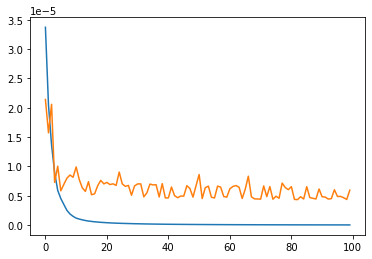

In [5]:
import matplotlib.pyplot as plt

plt.plot(train_loss_list)
plt.plot(valid_loss_list)
plt.show()

In [14]:
from sklearn.metrics import confusion_matrix


pred = model(inputs)
pred_np = pred.detach().cpu().round()
labels_np = labels.detach().cpu()
confusion_matrix(pred_np[:, 1], labels_np[:,1])

array([[48,  0],
       [ 0, 12]], dtype=int64)

In [12]:
labels_np.shape

torch.Size([60, 6])